# Averging, Filtering and Low Passing Data

This tutorial covers the filtering tools in VTools as well as some motivation as to when and why you might do that instead of something simpler like taking a daily average. Sometimes doing that creates a 100% error and sometimes it is trivial ... when?

VTools provides simple methods for period averaging, filtering and low passing data, particularly tidal data. Basic period averaging and daily averaging is easily covered by the regular Pandas API, but these methods can distort tidal data or yield unepected results with missing data. 

As an introduction to the topic let's start by making a single time series with three of the most common tidal constituents. This produces a series that is complex enough to be interesting and realistic, but it doesn't have any low frequencies in it, so a reasonable tidal filtration should look like a flat line at zero. 

Text(0, 0.5, 'm')

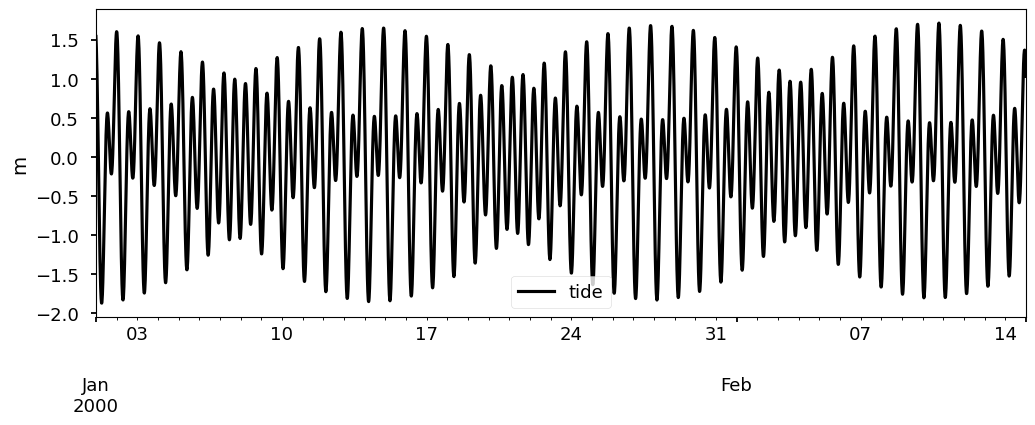

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.signal
from vtools.data.vtime import minutes,days,months
from vtools.functions.period_op import period_op
from vtools.functions.filter import cosine_lanczos,lanczos,godin,butterworth

plt.style.use(['seaborn-v0_8-colorblind','seaborn-v0_8-talk'])
mpl.rcParams['figure.figsize'] = [12,4.]

delta_t = minutes(15)  # creating a real offset instead of a string because it will be used in algebra shortly
ndx = pd.date_range("2000-01-01","2000-02-15",freq=delta_t)
thours = 0.25*np.arange(len(ndx))
twopi = 2.*np.pi
M2 = np.cos(twopi*thours/12.4)
K1 = 0.5*np.cos(twopi*thours/23.9+1.)
O1 = 0.5*np.cos(twopi*thours/25.8+1.)
tide = M2 + O1 + K1
df = pd.DataFrame(index=ndx,data={"tide": tide})
ax=df.plot(color="black")
ax.set_ylabel("m")






Now consider the ways you might average or filter this series. The desired outcome is just a line at zero. 

One approach is a 24-hour boxcar average. A boxcar average is moving window average, that puts equal weight in all the points in the window. This is not the same as a daily average because the output is defined/recalculated at each of the original 15min points. There is no way to center a 24 hour average so that it is centered perfectly, because there are an even number of samples. The fact that odd numbers are needed for a centered filter may be unintuitive, but just think of your hand -- there is only a middle finger because you have an odd number of fingers. 

A true daily average results in one value per day. Pandas can do this with `df.resample('d').mean()`. The time centering of the result won't have much meaning in this case -- it is a period average. You also have to watch out for missing data and boundary effects. Pandas will attempt to complete the average even if given just a few values even though this can cause absurd values near data boundaries or missing data. An example is showin in the plot below, and the value is so bad it had to be truncated. The vtools `period_op` allows you to specify the fraction of allowed missing data which should be set fairly low, say between 0.0 and 0.1. The fact that Pandas doesn't have a switch for this is uncharacteristic of their programming interface -- they often have arguments  (like min_periods for `rolling()` operations) that will help you specify a minimum number of data.  

Finally, note that the boxcar and daily average are related. A daily average can be thought of as a boxcar that is subsequently resampled one sample per day and then had its timestamp shifted from the middle of the period to whatever point is used to index the period. We've added markers to the VTools daily average in the plot below to show the idea of this resampling.  Each green point is a snapshot of the blue boxcar which has then been shifted ~12 hours to the left to move the timestamp. Sampling the predominantly 25-hour signal using 24 hour based averages or point values causes something called "aliasing". A spurious frequency (14-day signal) is caused by visiting the tidal wiggles once per day in different places in the tide cycle ... we've seen these spurious signals analyzed as if they were real.



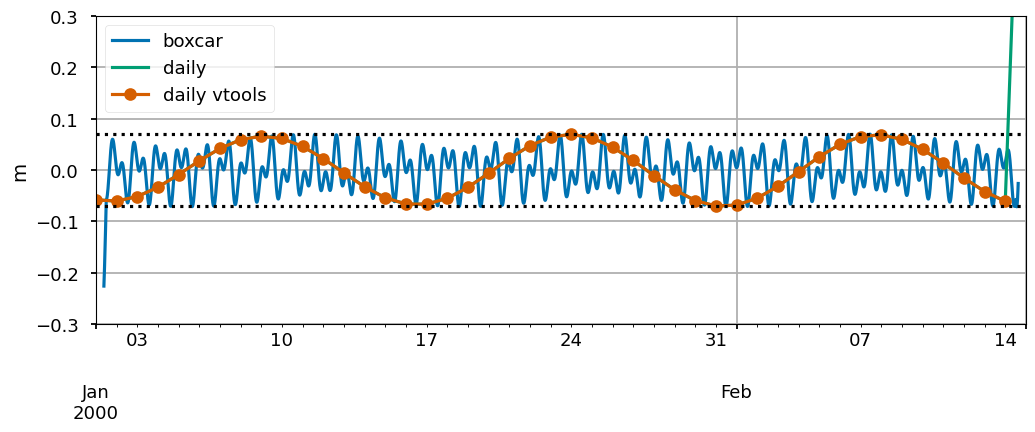

In [2]:
samples_day = 96
box = df.rolling(samples_day,center=True,min_periods=85).mean()
daily = df.resample('d').mean()
daily_vtools = period_op(df,period = "d",agg="mean",max_absent_frac=0.)

ax = box.plot()
daily.plot(ax=ax)
daily_vtools.plot(ax=ax,style=['-o'])
ax.grid()
ax.set_ylim(-0.3,0.3)
ax.axhline(y=-0.07,color="black",linestyle=":")
ax.axhline(y=0.07,color="black",linestyle=":")
ax.set_ylabel('m')

plt.legend(["boxcar","daily","daily vtools"])
plt.show()

Next comes the all-important question: how much do the wiggles matter? Importance depends on the signal and the context of the analysis, but in a predictable way. The strength of the wiggles will be about 3-5% of the tidal range of the original signal -- we will see this below. In the present case that tidal range was a bit over 1.5m. The size of the wiggles is thus about 0.5-0.07m. To show that, a dotted line is drawn at +/- 0.07m on the plot.

If you are trying to filter discharge at Rio Vista on the Sacramento River, the tides have an amplitude of 150,000cfs and the mean signal you are trying to extract could be as amall as 3,000cfs during a dry summer. Using the 5% rule, the spurious wiggles will be 7,500cfs, and will dominate your analysis. Even worse -- it will look real and it will seem like a spring-neap effect and people will interpret the wiggles. For water levels, the situation would be less bad. At Rio Vista, the tidal amplitude is perhaps 1m, so the filter wiggles will be about 5cm -- detectable but it is mostly just a 5% error. Similarly, aliasing errors are often not the biggest weakness in a salinity analysis. 

The right way to obtain daily values is decimation: use a good tidal filter and then sample once per day. Although Godin is well known in the Delta community for a particular filter, he was much more emphatic about that point about daily data than about particular filters. 

# Filters
Both daily averaging and 24-hour moving averages are problematic for tidal quantities because they are calendar/solar day methods being applied to a signal that is largely lunar in nature. The simplest filter you could use in the above case is a boxcar that is more tuned to the 24.8 lunar period. This might be implemented using an averaging period of 25 values for hourly data or 99 15 minute samples. In the code below I've been a bit fussier about the required data, allowing no misisng data and avoiding the "crazy" values at the end. As you can see from the blue and orange lines,the issues are reduced in the fillowing plot by half. 

We can go a bit further and use a real tidal filter. These filters are like moving averages, but their weights are not equal like a boxcar filter. Below are a couple examples. One is the so-called "Godin" filter which gained popularity because it could be constructed from successive boxcar ingredients -- one 25 hour boxcar that is centered on the time point under analysis and two 24 hour boxcars that are staggered to the left and right by one sample so that overall they produce a centered effect. It can be done in Excel but there is a function in the vtools toolkit too.

The last filters are Lanczos and cosine-Lanczos. Note that both the Godin and cosine-Lanczos filters produce an almost entirely flat response in the stop band. They completely supress the tide. We'll worry in a few moments about what good things they may have suppressed as well. As a practical matter, note that the Godin line has fewer missing values at the beginning and end of the series than the cosine-Lanczos. This is because it is a shorter filter that has non-zero weights over a briefer period. Tidal filters often produce nans at the beginning and end of the data set


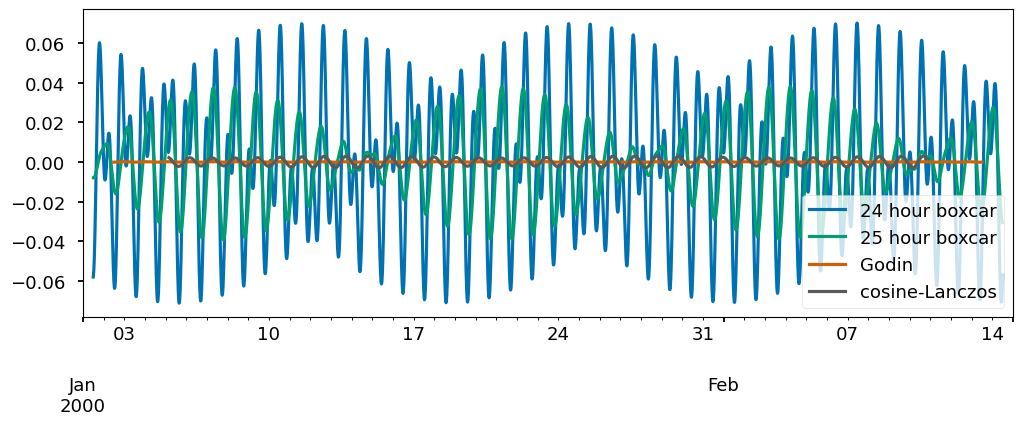

In [3]:
samples_tidal_day = 99
box24 = df.rolling(samples_day,center=True,min_periods=96).mean()
box25 = df.rolling(samples_tidal_day,center=True,min_periods=99).mean()
gdn = godin(df)
coslan = cosine_lanczos(df,'40h')
ax1 = box24.plot()
box25.plot(ax=ax1)
gdn.plot(ax=ax1)
coslan.plot(ax=ax1,color="0.35")
ax1.legend(['24 hour boxcar','25 hour boxcar','Godin','cosine-Lanczos'])

So at this point we've tested the ability of the filters to eliminate the tides, their so-called stopband characteristics. Now what about their ability to capture or "pass" the lower frequencies that are of interest? For this we need to add a subtidal (slow varying) component to the tide. To do this we will use a function called a "chirp" which transitions from a period of 12 days to a period of 4 days -- in both cases much longer than a tidal day.

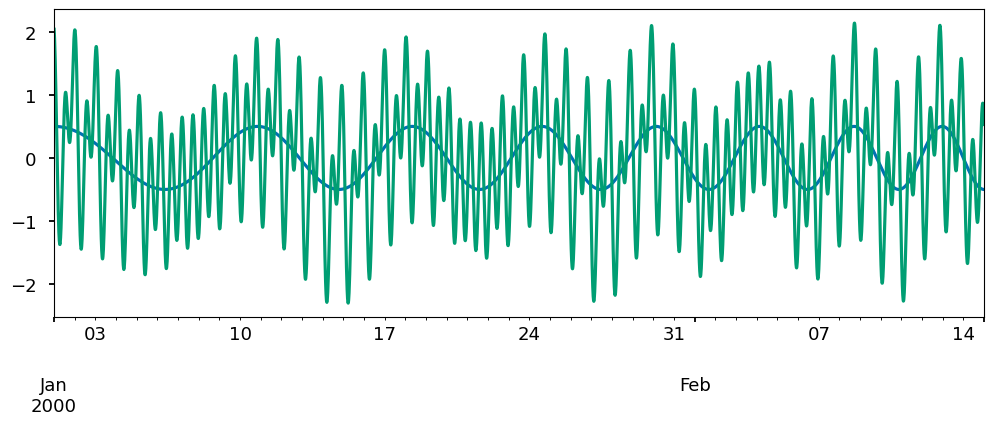

In [4]:

# Create the chirp and show it.
f0=1./(24.*12.)
f1=1./(24.*4)
subtide = 0.5*scipy.signal.chirp(thours, f0, thours[-1], f1, method='linear', phi=0, vertex_zero=True)
dfsub = pd.DataFrame(index=df.index,data=subtide)
ax=dfsub.plot()


# Add it to the original tide
df_with_sub = df.squeeze() + dfsub.squeeze()
df_with_sub = df_with_sub.to_frame()
df_with_sub.plot(ax=ax)
ax.get_legend().remove()
plt.show()

Now we attempt to extract the known subtidal signals using some of the tidal averages and filters. Doing so reveals differences that may be significant in some applications. The Godin filter attenuates signals with periods of 3-7 days by as much as 30%. The 25-hour boxcar (which is one of the "ingredients" of the Godin filter) attenuates less, but adds wiggles. The cosine-Lanczos filter is better in both regards, but as we have already mentioned it amplifies gaps and boundary effects. One useful step to help minimize this is to interpolate small gaps before applying the filter. The way to do this is shown in the first step in the followoing snippet, but of course it wouldn't do anything here because there is no missing data.

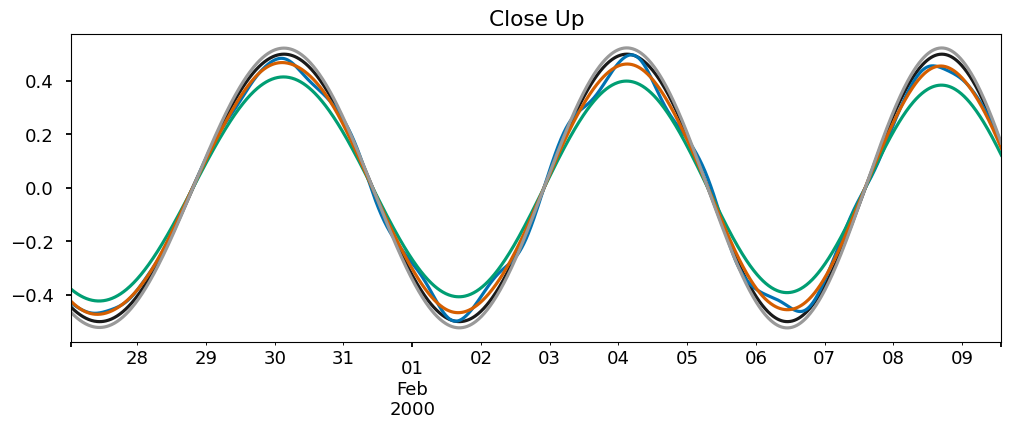

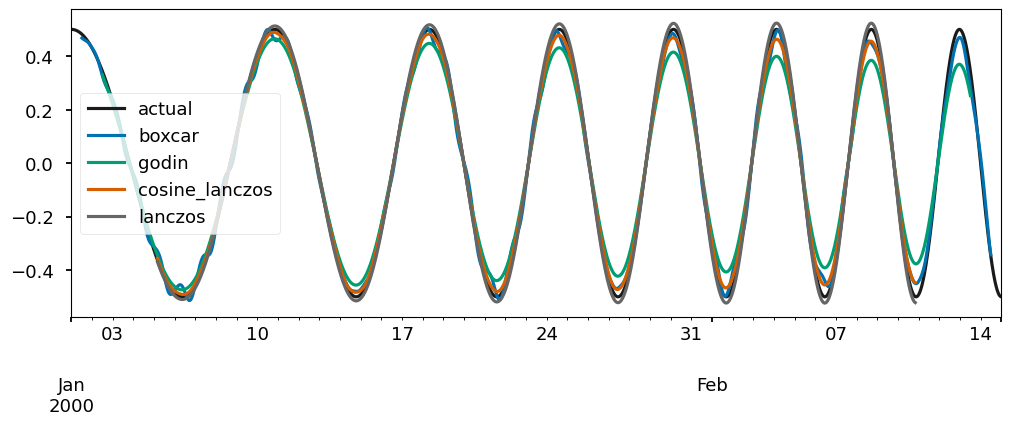

In [5]:
# Linear by default, this will leave any gaps longer than 4 samples. In this case there is none so this does nothing.
df_with_sub = df_with_sub.interpolate(limit=4)  

box25 = df_with_sub.rolling(99,center=True).mean()   # Boxcar spanning 99 15min values
gdnsub = godin(df_with_sub)                          # Godin
cl_sub = cosine_lanczos(df_with_sub,'40h')           # cosine-Lanzos squared
l_sub = lanczos(df_with_sub,'40h')


ax1=dfsub.iloc[2500:3800].plot(color="0.1")
box25.iloc[2500:3800].plot(ax=ax1)
gdnsub.iloc[2500:3800].plot(ax=ax1)
cl_sub.iloc[2500:3800].plot(ax=ax1)
l_sub.iloc[2500:3800].plot(ax=ax1,color="0.6")

ax=dfsub.plot(color="0.1")
box25.plot(ax=ax)
gdnsub.plot(ax=ax)
cl_sub.plot(ax=ax)
l_sub.plot(ax=ax,color="0.4")
ax.legend(["actual","boxcar","godin","cosine_lanczos","lanczos"])
ax1.set_title("Close Up")
ax1.get_legend().remove()


plt.show()

The passband, stopband and fidelity of the filters can be compared by looking at their frequency response as shown below. The response shows why we need to use 40h as the cutoff for the cosine-Lanczos filter to make sure it is really near zero by the diurnal periods of O1 and K1. You will be able to see that the boxcars pick up 5% of the tidal frequencies in a "bump" in the stopband, particularly the diurnal frequencies. Finally, note that the Godin filter performance in the pass band is quite attenuated -- at periods of 100 hours, the attenuation is more than 20%. The Lanczos filter without the cosine taper slightly exaggerates signals in that range. 

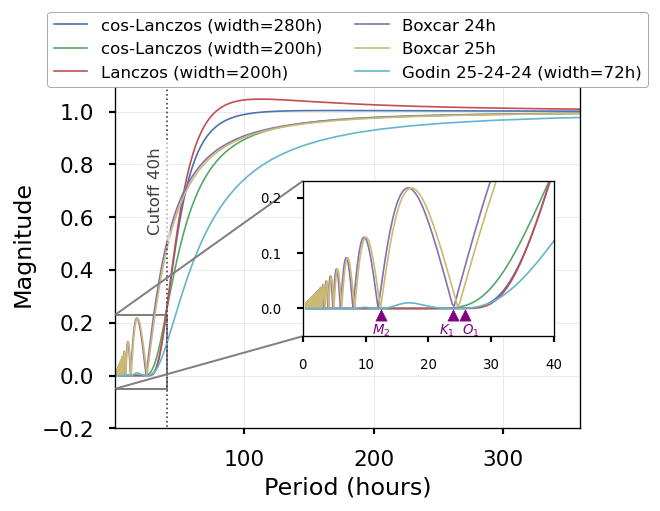

In [8]:
from vtools.functions.frequency_response import compare_response
compare_response(40)



VTools also provides a simplified interface to the Butterworth filter. However, Butterworth filters are members of the class of "infinite impulse response" filters. These are kind of hard to use for imperfect, gappy data.
